In [248]:
%run homework_modules.ipynb

In [194]:
import torch
from torch.autograd import Variable
import numpy as np
import unittest

In [250]:
class TestLayers(unittest.TestCase):
    def test_Linear(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in, n_out = 2, 3, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Linear(n_in, n_out)
            custom_layer = Linear(n_in, n_out)
            custom_layer.W = torch_layer.weight.data.numpy()
            custom_layer.b = torch_layer.bias.data.numpy()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

            # 3. check layer parameters grad
            custom_layer.accGradParameters(layer_input, next_layer_grad)
            weight_grad = custom_layer.gradW
            bias_grad = custom_layer.gradb
            torch_weight_grad = torch_layer.weight.grad.data.numpy()
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_SoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Softmax(dim=1)
            custom_layer = SoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)
            next_layer_grad = next_layer_grad.clip(1e-5,1.)
            next_layer_grad = 1. / next_layer_grad

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

    def test_LogSoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.LogSoftmax(dim=1)
            custom_layer = LogSoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_BatchNormalization(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 32, 16
        for _ in range(100):
            # layers initialization
            slope = np.random.uniform(0.01, 0.05)
            alpha = 0.9
            custom_layer = BatchNormalization(alpha)
            custom_layer.train()
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=custom_layer.EPS, momentum=1.-alpha, affine=False)
            custom_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

            # 3. check moving mean
            self.assertTrue(np.allclose(custom_layer.moving_mean, torch_layer.running_mean.numpy()))
            # we don't check moving_variance because pytorch uses slightly different formula for it:
            # it computes moving average for unbiased variance (i.e var*N/(N-1))
            #self.assertTrue(np.allclose(custom_layer.moving_variance, torch_layer.running_var.numpy()))

            # 4. check evaluation mode
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.evaluate()
            custom_layer_output = custom_layer.updateOutput(layer_input)
            torch_layer.eval()
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

    def test_Sequential(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            alpha = 0.9
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=BatchNormalization.EPS, momentum=1.-alpha, affine=True)
            torch_layer.bias.data = torch.from_numpy(np.random.random(n_in).astype(np.float32))
            custom_layer = Sequential()
            bn_layer = BatchNormalization(alpha)
            bn_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            bn_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.add(bn_layer)
            scaling_layer = ChannelwiseScaling(n_in)
            scaling_layer.gamma = torch_layer.weight.data.numpy()
            scaling_layer.beta = torch_layer.bias.data.numpy()
            custom_layer.add(scaling_layer)
            custom_layer.train()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.backward(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-4))

            # 3. check layer parameters grad
            weight_grad, bias_grad = custom_layer.getGradParameters()[1]
            torch_weight_grad = torch_layer.weight.grad.data.numpy()
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_Dropout(self):
        np.random.seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            p = np.random.uniform(0.3, 0.7)
            layer = Dropout(p)
            layer.train()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.all(np.logical_or(np.isclose(layer_output, 0),
                                        np.isclose(layer_output*(1.-p), layer_input))))

            # 2. check layer input grad
            layer_grad = layer.updateGradInput(layer_input, next_layer_grad)
            self.assertTrue(np.all(np.logical_or(np.isclose(layer_grad, 0),
                                        np.isclose(layer_grad*(1.-p), next_layer_grad))))

            # 3. check evaluation mode
            layer.evaluate()
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.allclose(layer_output, layer_input))

            # 4. check mask
            p = 0.0
            layer = Dropout(p)
            layer.train()
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.allclose(layer_output, layer_input))

            p = 0.5
            layer = Dropout(p)
            layer.train()
            layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            layer_output = layer.updateOutput(layer_input)
            zeroed_elem_mask = np.isclose(layer_output, 0)
            layer_grad = layer.updateGradInput(layer_input, next_layer_grad)
            self.assertTrue(np.all(zeroed_elem_mask == np.isclose(layer_grad, 0)))

            # 5. dropout mask should be generated independently for every input matrix element, not for row/column
            batch_size, n_in = 1000, 1
            p = 0.8
            layer = Dropout(p)
            layer.train()

            layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.sum(np.isclose(layer_output, 0)) != layer_input.size)

            layer_input = layer_input.T
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.sum(np.isclose(layer_output, 0)) != layer_input.size)

    def test_Conv2d(self):
        hyperparams = [
            {'batch_size': 8, 'in_channels': 3, 'out_channels': 6, 'height': 32, 'width': 32,
             'kernel_size': 3, 'stride': 1, 'padding': 1, 'bias': True, 'padding_mode': 'zeros'},
            {'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28,
             'kernel_size': 5, 'stride': 2, 'padding': 2, 'bias': False, 'padding_mode': 'replicate'},
            {'batch_size': 16, 'in_channels': 3, 'out_channels': 3, 'height': 64, 'width': 64,
             'kernel_size': 3, 'stride': 2, 'padding': 'same', 'bias': True, 'padding_mode': 'reflect'},
            {'batch_size': 2, 'in_channels': 3, 'out_channels': 8, 'height': 10, 'width': 10,
             'kernel_size': 2, 'stride': (1,2), 'padding': 0, 'bias': True, 'padding_mode': 'zeros'},
        ]
        np.random.seed(42)
        torch.manual_seed(42)

        for _ in range(100):
          for params in hyperparams:
              with self.subTest(params=params):

                  batch_size = params['batch_size']
                  in_channels = params['in_channels']
                  out_channels = params['out_channels']
                  height = params['height']
                  width = params['width']
                  kernel_size = params['kernel_size']
                  stride = params['stride']
                  padding = params['padding']
                  bias = params['bias']
                  padding_mode = params['padding_mode']

                  custom_layer = Conv2d(in_channels, out_channels, kernel_size,
                                        stride=stride, padding=padding, bias=bias,
                                        padding_mode=padding_mode)
                  custom_layer.train()

                  torch_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                                stride=stride, padding=padding, bias=bias,
                                                padding_mode=padding_mode)

                  custom_layer.weight = torch_layer.weight.detach().numpy().copy()
                  if bias:
                      custom_layer.bias = torch_layer.bias.detach().numpy().copy()

                  layer_input = np.random.randn(batch_size, in_channels, height, width).astype(np.float32)
                  input_var = torch.tensor(layer_input, requires_grad=True)

                  custom_output = custom_layer.updateOutput(layer_input)
                  torch_output = torch_layer(input_var)
                  self.assertTrue(
                      np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

                  next_layer_grad = np.random.randn(*torch_output.shape).astype(np.float32)
                  custom_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
                  torch_output.backward(torch.tensor(next_layer_grad))
                  torch_grad = input_var.grad.detach().numpy()
                  self.assertTrue(
                      np.allclose(torch_grad, custom_grad, atol=1e-5))


    def test_LeakyReLU(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            slope = np.random.uniform(0.01, 0.05)
            torch_layer = torch.nn.LeakyReLU(slope)
            custom_layer = LeakyReLU(slope)

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ELU(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            alpha = 1.0
            torch_layer = torch.nn.ELU(alpha)
            custom_layer = ELU(alpha)

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_SoftPlus(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Softplus()
            custom_layer = SoftPlus()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ClassNLLCriterionUnstable(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.NLLLoss()
            custom_layer = ClassNLLCriterionUnstable()

            layer_input = np.random.uniform(0, 1, (batch_size, n_in)).astype(np.float32)
            layer_input /= layer_input.sum(axis=-1, keepdims=True)
            layer_input = layer_input.clip(custom_layer.EPS, 1. - custom_layer.EPS)  # unifies input
            target_labels = np.random.choice(n_in, batch_size)
            target = np.zeros((batch_size, n_in), np.float32)
            target[np.arange(batch_size), target_labels] = 1  # one-hot encoding

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input, target)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(torch.log(layer_input_var),
                                                 Variable(torch.from_numpy(target_labels).long(), requires_grad=False))
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ClassNLLCriterion(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.NLLLoss()
            custom_layer = ClassNLLCriterion()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            layer_input = torch.nn.LogSoftmax(dim=1)(Variable(torch.from_numpy(layer_input))).data.numpy()
            target_labels = np.random.choice(n_in, batch_size)
            target = np.zeros((batch_size, n_in), np.float32)
            target[np.arange(batch_size), target_labels] = 1  # one-hot encoding

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input, target)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var,
                                                 Variable(torch.from_numpy(target_labels).long(), requires_grad=False))
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-4))


    def test_MaxPool2d(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, channels, height, width = 4, 3, 16, 16
        kernel_size, stride, padding = 2, 2, 0

        for _ in range(100):
          custom_module = MaxPool2d(kernel_size, stride, padding)
          custom_module.train()

          torch_module = torch.nn.MaxPool2d(kernel_size, stride=stride, padding=padding)

          input_np = np.random.randn(batch_size, channels, height, width).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-5))

    def test_AvgPool2d(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, channels, height, width = 4, 3, 16, 16
        kernel_size, stride, padding = 3, 2, 1

        for _ in range(100):
          custom_module = AvgPool2d(kernel_size, stride, padding)
          custom_module.train()

          torch_module = torch.nn.AvgPool2d(kernel_size, stride=stride, padding=padding)

          input_np = np.random.randn(batch_size, channels, height, width).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-5))

    def test_Flatten(self):
        np.random.seed(42)
        torch.manual_seed(42)

        test_params = [
            {'start_dim': 1, 'end_dim': -1},
            {'start_dim': 2, 'end_dim': 3},
            {'start_dim': 0, 'end_dim': -1},
        ]

        for _ in range(100):
          for params in test_params:
              with self.subTest(params=params):
                  start_dim = params['start_dim']
                  end_dim = params['end_dim']

                  custom_module = Flatten(start_dim, end_dim)
                  input_np = np.random.randn(2, 3, 4, 5).astype(np.float32)
                  input_var = torch.tensor(input_np, requires_grad=True)

                  custom_output = custom_module.updateOutput(input_np)
                  torch_output = torch.flatten(input_var, start_dim=start_dim, end_dim=end_dim)
                  self.assertTrue(
                      np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

                  next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
                  custom_grad = custom_module.updateGradInput(input_np, next_grad)
                  torch_output.backward(torch.tensor(next_grad))
                  torch_grad = input_var.grad.detach().numpy()
                  self.assertTrue(
                      np.allclose(torch_grad, custom_grad, atol=1e-6))

    def test_Gelu(self):
        np.random.seed(42)
        torch.manual_seed(42)

        for _ in range(100):
          custom_module = Gelu()
          custom_module.train()

          torch_module = torch.nn.GELU()

          input_np = np.random.randn(10, 5).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-5))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-4))

    def test_GlobalAvgPool2d(self):
        np.random.seed(42)
    
        custom_layer = GlobalAvgPool2d()
        input_tensor = np.random.rand(2, 3, 4, 4).astype(np.float32)
        grad_output = np.ones((2, 3), dtype=np.float32)
    
        custom_output = custom_layer.updateOutput(input_tensor)  # ← ВАЖНО: вызов с ()
        expected_output = np.mean(input_tensor, axis=(2, 3))
    
        self.assertTrue(np.allclose(custom_output, expected_output, atol=1e-6))
    
        custom_grad = custom_layer.updateGradInput(input_tensor, grad_output)
        expected_grad = np.ones_like(input_tensor) * (1 / (4 * 4))
        self.assertTrue(np.allclose(custom_grad, expected_grad, atol=1e-6))


    def test_GlobalMaxPool2d(self):
        np.random.seed(42)
    
        custom_layer = GlobalMaxPool2d()
        input_tensor = np.random.rand(2, 3, 4, 4).astype(np.float32)
        grad_output = np.ones((2, 3), dtype=np.float32)
    
        custom_output = custom_layer.updateOutput(input_tensor)
        expected_output = np.max(input_tensor, axis=(2, 3))
        self.assertTrue(np.allclose(custom_output, expected_output, atol=1e-6))
    
        custom_grad = custom_layer.updateGradInput(input_tensor, grad_output)
        expected_grad = np.zeros_like(input_tensor)
        mask = (input_tensor == np.max(input_tensor, axis=(2, 3), keepdims=True))
        expected_grad[mask] = 1.0
        self.assertTrue(np.allclose(custom_grad, expected_grad, atol=1e-6))



suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite)

test_AvgPool2d (__main__.TestLayers.test_AvgPool2d) ... ok
test_BatchNormalization (__main__.TestLayers.test_BatchNormalization) ... ok
test_ClassNLLCriterion (__main__.TestLayers.test_ClassNLLCriterion) ... ok
test_ClassNLLCriterionUnstable (__main__.TestLayers.test_ClassNLLCriterionUnstable) ... ok
test_Conv2d (__main__.TestLayers.test_Conv2d) ... 
  test_Conv2d (__main__.TestLayers.test_Conv2d) (params={'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28, 'kernel_size': 5, 'stride': 2, 'padding': 2, 'bias': False, 'padding_mode': 'replicate'}) ... FAIL
  test_Conv2d (__main__.TestLayers.test_Conv2d) (params={'batch_size': 16, 'in_channels': 3, 'out_channels': 3, 'height': 64, 'width': 64, 'kernel_size': 3, 'stride': 2, 'padding': 'same', 'bias': True, 'padding_mode': 'reflect'}) ... ERROR
  test_Conv2d (__main__.TestLayers.test_Conv2d) (params={'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28, 'kernel_size': 5, 'stride': 2, 

<unittest.runner.TextTestResult run=18 errors=101 failures=100>

#### Саммари:
Сработало функций: 16/18 штук

# 2 часть

In [155]:
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T

from torch.utils.data import Dataset, DataLoader

## Пункт 1

In [156]:
class SGD(object):
    def __init__(self, parameters, lr=0.01, momentum=0.0, weight_decay=0.0):
        """
        Инициализация оптимизатора SGD.
        
        Параметры:
        - parameters: список параметров для оптимизации 
        - lr: learning rate 
        - momentum: коэффициент момента
        - weight_decay: коэффициент L2 регуляризации
        """
        self.parameters = parameters
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.velocity = []  # Для хранения скорости при использовании момента
        
        # Инициализация velocity для каждого параметра
        for param in self.parameters:
            self.velocity.append(np.zeros_like(param))
    
    def step(self):
        """
        Выполняет один шаг оптимизации, обновляя параметры.
        """
        for i, (param, grad) in enumerate(zip(self.parameters, self.getGradParameters())):
            if grad is None:
                continue
                
            # L2 регуляризация
            if self.weight_decay != 0:
                grad += self.weight_decay * param
                
            # Обновление скорости с моментом
            if self.momentum != 0:
                self.velocity[i] = self.momentum * self.velocity[i] + grad
                update = -self.lr * self.velocity[i]
            else:
                update = -self.lr * grad
                
            # Обновление параметров
            param += update
    
    def zeroGrad(self):
        """
        Обнуляет градиенты всех параметров.
        """
        for grad in self.getGradParameters():
            if grad is not None:
                grad.fill(0)
    
    def getGradParameters(self):
        """
        Возвращает список градиентов для всех параметров.
        """
        grads = []
        for param_group in self.parameters:
            if isinstance(param_group, (list, tuple)):
                for p in param_group:
                    if hasattr(p, 'grad'):
                        grads.append(p.grad)
                    else:
                        grads.append(None)
            else:
                if hasattr(param_group, 'grad'):
                    grads.append(param_group.grad)
                else:
                    grads.append(None)
        return grads
    
    def __repr__(self):
        return f"SGD(lr={self.lr}, momentum={self.momentum}, weight_decay={self.weight_decay})"

## Пункт 2

Решение задачи на примере временных рядов инфляции. 

In [169]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [170]:
data = pd.read_csv('CPIAUCSL.csv')

In [171]:
data.head()

,observation_date,CPIAUCSL
0,2000-01-01,169.3
1,2000-02-01,170.0
2,2000-03-01,171.0
3,2000-04-01,170.9
4,2000-05-01,171.2


In [173]:
prices = data['CPIAUCSL'].values.reshape(-1, 1)

In [174]:
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

In [177]:
def create_dataset(data, window_size=12, forecast_horizon=3):
    X, y = [], []
    for i in range(len(data)-window_size-forecast_horizon):
        X.append(data[i:(i+window_size), 0])  
        y.append(data[(i+window_size):(i+window_size+forecast_horizon), 0])  
    return np.array(X), np.array(y)

window_size = 12
forecast_horizon = 3 
X, y = create_dataset(prices_scaled, window_size, forecast_horizon)

X.shape, y.shape

((287, 12), (287, 3))

In [216]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, 
                 activation='relu', dropout_p=0.2, use_batchnorm=True):
        super().__init__()
        self.layers = []
        prev_size = input_size
        
        for i, h_size in enumerate(hidden_sizes):
            self.layers.append(Linear(prev_size, h_size))
            
            if use_batchnorm:
                self.layers.append(BatchNormalization())
                
            if activation == 'relu':
                self.layers.append(ReLU())
            elif activation == 'leakyrelu':
                self.layers.append(LeakyReLU())
            elif activation == 'elu':
                self.layers.append(ELU())
                
            if dropout_p > 0:
                self.layers.append(Dropout(dropout_p))
                
            prev_size = h_size
        
        self.layers.append(Linear(prev_size, output_size))
        self.net = Sequential()
        for layer in self.layers:
            self.net.add(layer)
    
    def forward(self, x):
        return self.net.forward(x)
    
    def backward(self, x, grad_output):
        return self.net.backward(x, grad_output)
    
    def get_parameters(self):
        return self.net.getParameters()


In [214]:
# Маленькая модель
small_model = FCNN(input_size=window_size, 
                  hidden_sizes=[64], 
                  output_size=3,
                  activation='relu',
                  dropout_p=0.1,
                  use_batchnorm=True)

# Средняя модель
medium_model = FCNN(input_size=window_size, 
                   hidden_sizes=[128, 64], 
                   output_size=3,
                   activation='leakyrelu',
                   dropout_p=0.2,
                   use_batchnorm=True)

# Большая модель
large_model = FCNN(input_size=window_size, 
                  hidden_sizes=[256, 128, 64], 
                  output_size=3,
                  activation='elu',
                  dropout_p=0.3,
                  use_batchnorm=True)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

In [227]:
class SGD:
    def __init__(self, parameters, lr=0.01, momentum=0.9, weight_decay=0.0):
        
        self.parameters = []
        self.velocity = []
        
        for param_group in parameters:
            if isinstance(param_group, dict):
                param = param_group['params']
                grad = param_group.get('grad', np.zeros_like(param))
            else:
                param = param_group
                grad = np.zeros_like(param)
            
            self.parameters.append({'params': np.array(param), 'grad': np.array(grad)})
            self.velocity.append(np.zeros_like(param))
        
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
    
    def step(self):
        for i, param_group in enumerate(self.parameters):
            param = param_group['params']
            grad = param_group['grad']
            
            # L2 регуляризация
            if self.weight_decay != 0:
                grad += self.weight_decay * param
                
            # Обновление скорости с моментом
            if self.momentum != 0:
                self.velocity[i] = self.momentum * self.velocity[i] + grad
                param -= self.lr * self.velocity[i]
            else:
                param -= self.lr * grad
    
    def zeroGrad(self):
        for param_group in self.parameters:
            param_group['grad'].fill(0)

def train2(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.01, batch_size=32):
    criterion = MSECriterion()
    
    parameters = []
    for layer in model.net.modules:
        if hasattr(layer, 'W'):
            parameters.append({'params': layer.W, 'grad': layer.gradW})
        if hasattr(layer, 'b'):
            parameters.append({'params': layer.b, 'grad': layer.gradb})
    
    optimizer = SGD(parameters, lr=lr, momentum=0.9)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.net.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            batch_x = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            # Forward
            output = model.forward(batch_x)
            loss = criterion.forward(output, batch_y)
            
            # Backward
            grad_output = criterion.backward(output, batch_y)
            model.backward(batch_x, grad_output)
            
            # Update
            optimizer.step()
            optimizer.zeroGrad()
            
            epoch_loss += loss
        
        train_losses.append(epoch_loss / (len(X_train)/batch_size))
        
        # Валидация
        model.net.evaluate()
        val_output = model.forward(X_val)
        val_loss = criterion.forward(val_output, y_val)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

def evaluate(model, X_test, y_test):
    criterion = MSECriterion()
    model.net.evaluate()
    test_output = model.forward(X_test)
    test_loss = criterion.forward(test_output, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    
    plt.figure(figsize=(12, 6))
    for i in range(min(3, y_test.shape[1])):  
        plt.subplot(3, 1, i+1)
        plt.plot(y_test[:, i], label='True')
        plt.plot(test_output[:, i], label='Predicted')
        plt.title(f'Month {i+1} Prediction')
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    return test_loss

Training small model...
Epoch 1/50, Train Loss: 0.3216, Val Loss: 1.1439
Epoch 2/50, Train Loss: 0.3229, Val Loss: 1.1439
Epoch 3/50, Train Loss: 0.3256, Val Loss: 1.1439
Epoch 4/50, Train Loss: 0.3270, Val Loss: 1.1439
Epoch 5/50, Train Loss: 0.3241, Val Loss: 1.1439
Epoch 6/50, Train Loss: 0.3258, Val Loss: 1.1439
Epoch 7/50, Train Loss: 0.3285, Val Loss: 1.1439
Epoch 8/50, Train Loss: 0.3237, Val Loss: 1.1439
Epoch 9/50, Train Loss: 0.3233, Val Loss: 1.1439
Epoch 10/50, Train Loss: 0.3224, Val Loss: 1.1439
Epoch 11/50, Train Loss: 0.3165, Val Loss: 1.1439
Epoch 12/50, Train Loss: 0.3272, Val Loss: 1.1439
Epoch 13/50, Train Loss: 0.3206, Val Loss: 1.1439
Epoch 14/50, Train Loss: 0.3229, Val Loss: 1.1439
Epoch 15/50, Train Loss: 0.3248, Val Loss: 1.1439
Epoch 16/50, Train Loss: 0.3251, Val Loss: 1.1439
Epoch 17/50, Train Loss: 0.3172, Val Loss: 1.1439
Epoch 18/50, Train Loss: 0.3278, Val Loss: 1.1439
Epoch 19/50, Train Loss: 0.3207, Val Loss: 1.1439
Epoch 20/50, Train Loss: 0.3306, Va

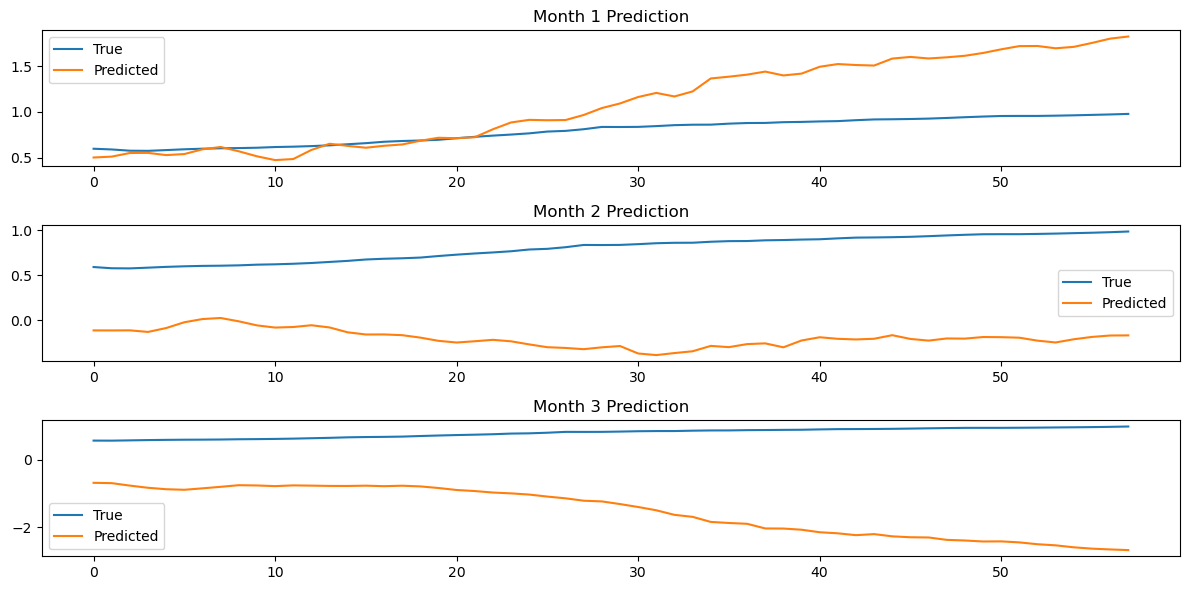


Training medium model...
Epoch 1/50, Train Loss: 0.7954, Val Loss: 3.5798
Epoch 2/50, Train Loss: 0.7728, Val Loss: 3.2119
Epoch 3/50, Train Loss: 0.7106, Val Loss: 5.3952
Epoch 4/50, Train Loss: 0.7159, Val Loss: 5.0747
Epoch 5/50, Train Loss: 0.7363, Val Loss: 5.3425
Epoch 6/50, Train Loss: 0.8071, Val Loss: 3.3849
Epoch 7/50, Train Loss: 0.8013, Val Loss: 4.3374
Epoch 8/50, Train Loss: 0.7468, Val Loss: 5.3042
Epoch 9/50, Train Loss: 0.7101, Val Loss: 5.4083
Epoch 10/50, Train Loss: 0.7735, Val Loss: 3.7609
Epoch 11/50, Train Loss: 0.7141, Val Loss: 3.9860
Epoch 12/50, Train Loss: 0.7866, Val Loss: 5.7516
Epoch 13/50, Train Loss: 0.7296, Val Loss: 3.1962
Epoch 14/50, Train Loss: 0.6710, Val Loss: 4.3647
Epoch 15/50, Train Loss: 0.7760, Val Loss: 4.1904
Epoch 16/50, Train Loss: 0.8168, Val Loss: 5.8553
Epoch 17/50, Train Loss: 0.7168, Val Loss: 4.1895
Epoch 18/50, Train Loss: 0.8173, Val Loss: 3.0643
Epoch 19/50, Train Loss: 0.7255, Val Loss: 5.6351
Epoch 20/50, Train Loss: 0.6955, 

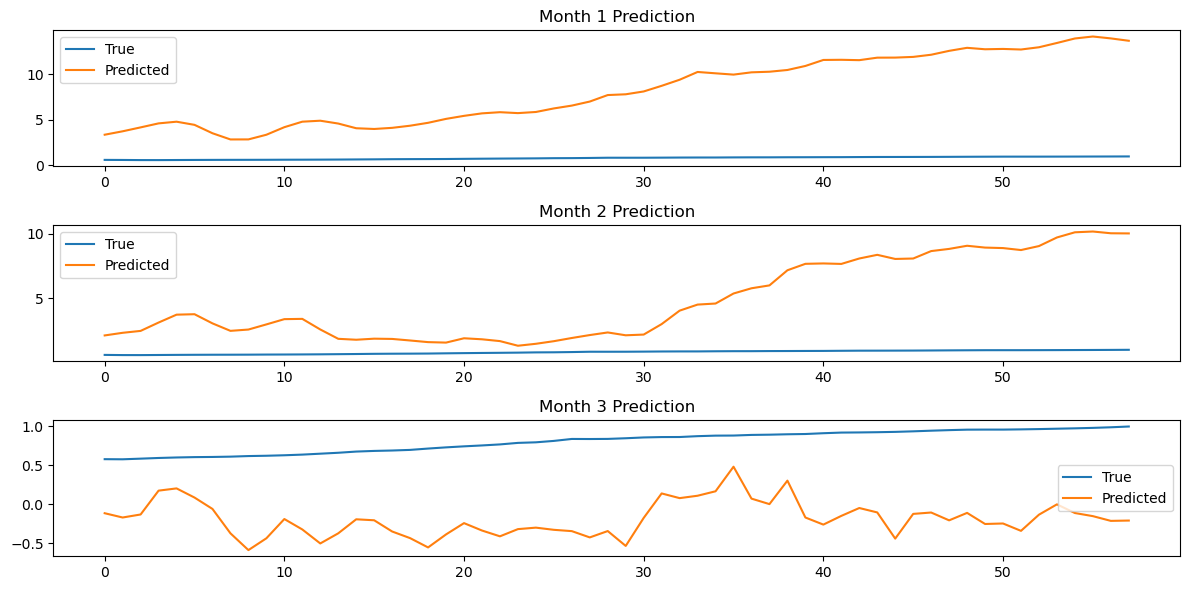


Training large model...
Epoch 1/50, Train Loss: 1.1912, Val Loss: 4.0804
Epoch 2/50, Train Loss: 1.1512, Val Loss: 4.0489
Epoch 3/50, Train Loss: 1.1986, Val Loss: 10.8153
Epoch 4/50, Train Loss: 1.3486, Val Loss: 14.0770
Epoch 5/50, Train Loss: 1.2521, Val Loss: 17.5811
Epoch 6/50, Train Loss: 1.3554, Val Loss: 4.8579
Epoch 7/50, Train Loss: 1.2305, Val Loss: 4.8015
Epoch 8/50, Train Loss: 1.3193, Val Loss: 10.0745
Epoch 9/50, Train Loss: 1.2697, Val Loss: 13.2614
Epoch 10/50, Train Loss: 1.1540, Val Loss: 17.8641
Epoch 11/50, Train Loss: 1.2968, Val Loss: 7.2306
Epoch 12/50, Train Loss: 1.3692, Val Loss: 9.7413
Epoch 13/50, Train Loss: 1.2286, Val Loss: 5.5946
Epoch 14/50, Train Loss: 1.1205, Val Loss: 7.7713
Epoch 15/50, Train Loss: 1.1848, Val Loss: 4.6801
Epoch 16/50, Train Loss: 1.3400, Val Loss: 15.0014
Epoch 17/50, Train Loss: 1.2995, Val Loss: 2.4623
Epoch 18/50, Train Loss: 1.1499, Val Loss: 13.7839
Epoch 19/50, Train Loss: 1.2173, Val Loss: 12.0143
Epoch 20/50, Train Loss: 

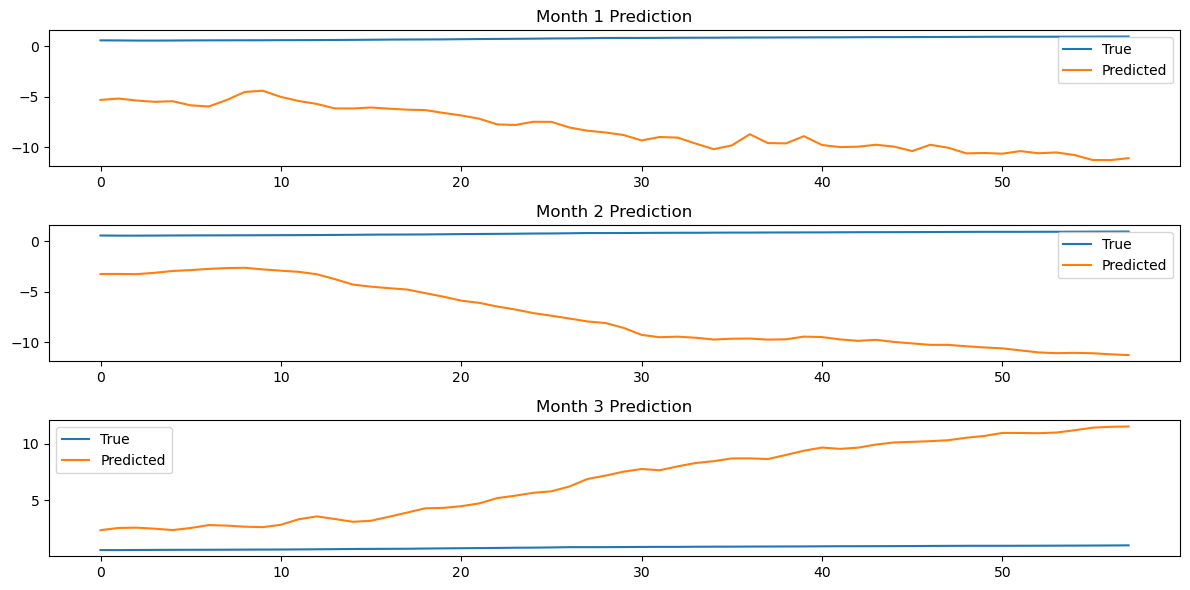

In [234]:
print("Training small model...")
train_loss_small, val_loss_small = train2(small_model, X_train, y_train, X_val, y_val, epochs=50, lr=0.01, batch_size=32)
test_loss_small = evaluate(small_model, X_test, y_test)

print("\nTraining medium model...")
train_loss_medium, val_loss_medium = train2(medium_model, X_train, y_train, X_val, y_val, epochs=50, lr=0.01, batch_size=32)
test_loss_medium = evaluate(medium_model, X_test, y_test)

print("\nTraining large model...")
train_loss_large, val_loss_large = train2(large_model, X_train, y_train, X_val, y_val, epochs=50, lr=0.01, batch_size=32)
test_loss_large = evaluate(large_model, X_test, y_test)

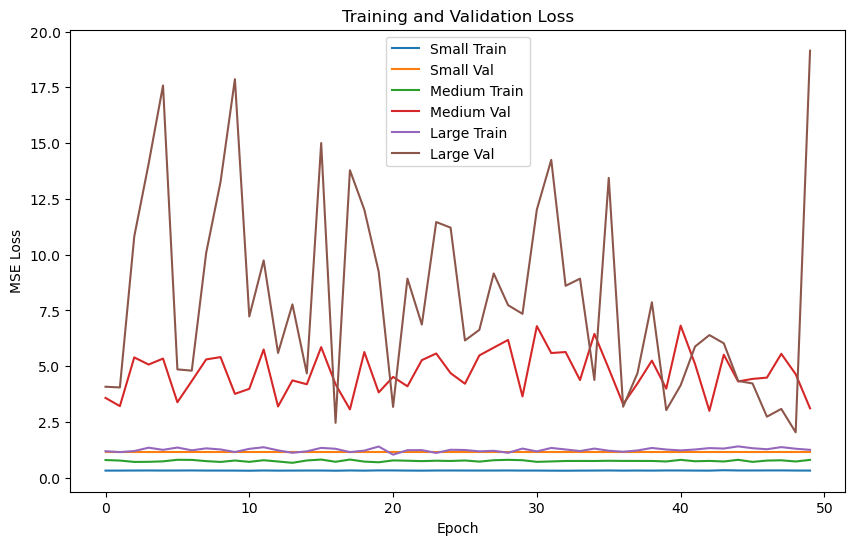

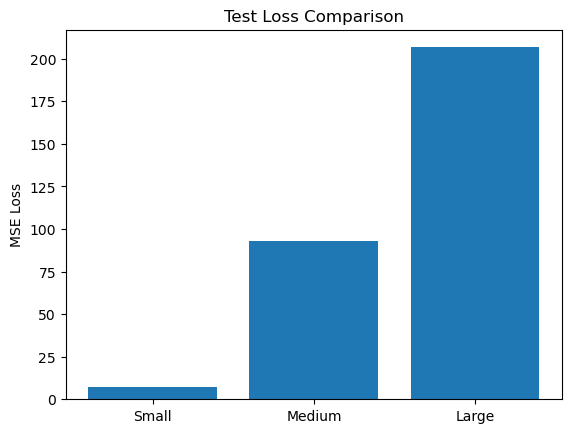

In [235]:
# Сравнение потерь
plt.figure(figsize=(10, 6))
plt.plot(train_loss_small, label='Small Train')
plt.plot(val_loss_small, label='Small Val')
plt.plot(train_loss_medium, label='Medium Train')
plt.plot(val_loss_medium, label='Medium Val')
plt.plot(train_loss_large, label='Large Train')
plt.plot(val_loss_large, label='Large Val')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Сравнение тестовых ошибок
models = ['Small', 'Medium', 'Large']
test_losses = [test_loss_small, test_loss_medium, test_loss_large]
plt.bar(models, test_losses)
plt.title('Test Loss Comparison')
plt.ylabel('MSE Loss')
plt.show()

## Пункт 3

In [137]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 1. Данные

In [138]:
transform = T.Compose(
    [
        T.ToTensor(),
#         T.Resize((32, 32)),
        T.Normalize((0.1307,), (0.3081,))
    ]
)

train_dataset = torchvision.datasets.MNIST(
    'MNIST', train=True, download=True, transform=transform
)
val_dataset = torchvision.datasets.MNIST(
    'MNIST', train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=4
)

In [139]:
# один батч
images, labels = next(iter(train_loader))

In [140]:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

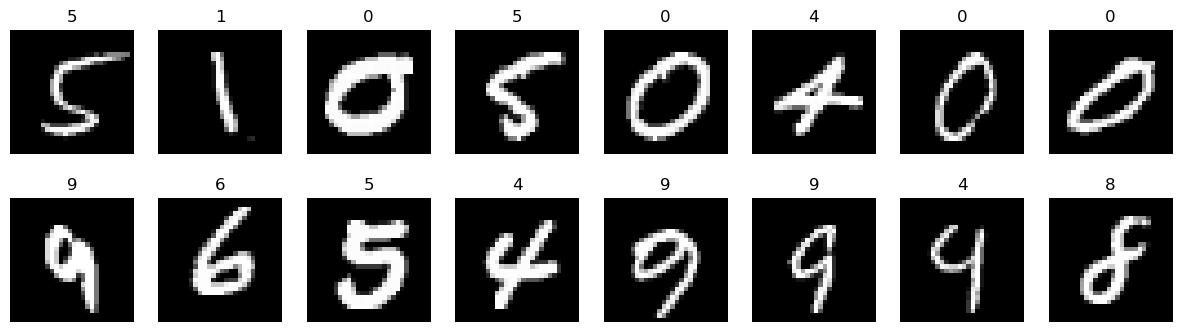

In [141]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(images[k], (1, 2, 0)), cmap='gray')
        ax.set_title(labels[k].item())
        k += 1
plt.show()

### 2. Функции для обучения

In [197]:
def train_epoch(model, optimizer, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

@torch.no_grad()
#test
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

def train(model, optimizer, criterion, train_loader, test_loader, num_epochs, scheduler=None):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train_epoch(
            model, optimizer, train_loader, 
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader, 
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [198]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    
    axs[0].plot(train_losses, label='train')
    
    #points = np.array(test_losses)
    axs[0].scatter(range(len(test_losses)), test_losses, marker='+', s=180, c='orange', label='val', zorder=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(train_accuracies, label='train')
    #points = np.array(test_accuracies)
    axs[1].scatter(range(len(test_accuracies)), test_accuracies, marker='+', s=180, c='orange', label='val', zorder=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('step')
        ax.legend()

    plt.show()

### 3. Сверточная сетка

In [144]:
INP_SHAPE = np.prod(images.shape[1:])
INP_SHAPE

784

In [145]:
class MyNet(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(  # 28 x 28
            nn.Conv2d(in_channels=image_channels, out_channels=8, 
                      kernel_size=3, padding='same'),  # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=8, out_channels=16, 
                      kernel_size=3, padding='same'),  # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7 x 7
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=784, out_features=392), # 90
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=10)
        )
    
    def forward(self, x):
        # x: B x 1 x 28 x 28
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = nn.Flatten()(out)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out
    
    def get_embedding(self, x):
        out = self.encoder(x)
        return nn.Flatten()(out)


In [146]:
model = MyNet().to(device)
num_epochs = 30
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

#history = train(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler)

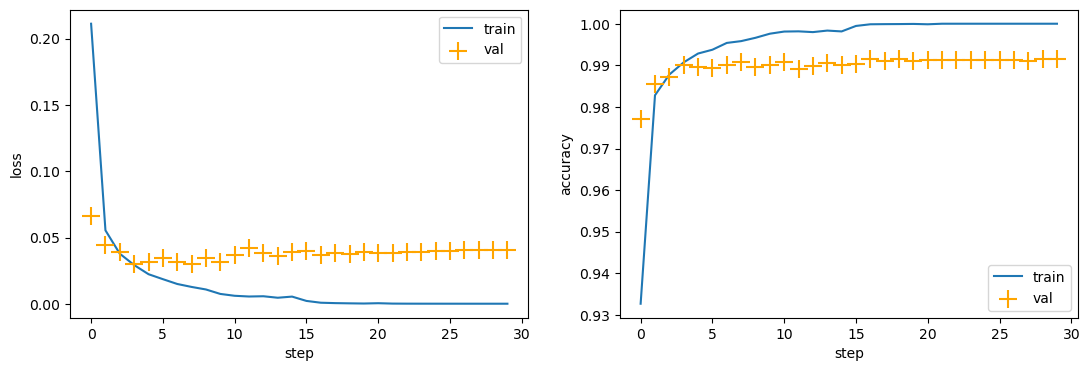

In [147]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, criterion, train_loader, val_loader, num_epochs
)

In [148]:
logits = model(images)
loss = criterion(logits, labels)

In [149]:
torch.argmax(logits, dim=1)

tensor([5, 1, 0, 5, 0, 4, 0, 0, 9, 6, 5, 4, 9, 9, 4, 8, 5, 3, 0, 6, 5, 1, 6, 6,
        9, 3, 0, 2, 3, 8, 3, 3, 7, 5, 1, 2, 6, 6, 4, 1, 7, 3, 3, 5, 7, 4, 0, 5,
        0, 7, 3, 6, 4, 7, 2, 0, 3, 8, 5, 5, 2, 5, 2, 7])

In [150]:
torch.max(logits, dim=1)

torch.return_types.max(
values=tensor([43.6486, 26.1325, 20.7968, 35.9825, 44.6421, 31.6785, 29.4845, 39.4943,
        30.1422, 52.9093, 43.8693, 40.9746, 35.7795, 30.0268, 27.4078, 30.0593,
        54.1370, 42.7324, 39.8968, 45.6892, 45.4877, 31.3164, 32.9966, 50.8388,
        37.1105, 51.2743, 44.3586, 23.3288, 35.6453, 51.6851, 28.5777, 51.9758,
        43.9771, 36.0100, 33.3986, 37.2035, 43.7150, 38.1642, 37.9394, 27.6990,
        41.2985, 25.3555, 48.4545, 35.3609, 37.2323, 37.0405, 39.2329, 25.0524,
        36.0000, 39.5696, 41.8466, 23.2648, 36.3872, 26.4720, 30.4592, 33.4053,
        26.9945, 25.9794, 49.0390, 43.3237, 57.5241, 41.1385, 41.4067, 34.3537],
       grad_fn=<MaxBackward0>),
indices=tensor([5, 1, 0, 5, 0, 4, 0, 0, 9, 6, 5, 4, 9, 9, 4, 8, 5, 3, 0, 6, 5, 1, 6, 6,
        9, 3, 0, 2, 3, 8, 3, 3, 7, 5, 1, 2, 6, 6, 4, 1, 7, 3, 3, 5, 7, 4, 0, 5,
        0, 7, 3, 6, 4, 7, 2, 0, 3, 8, 5, 5, 2, 5, 2, 7]))

In [151]:
pred = torch.max(logits, dim=1)[1].numpy()

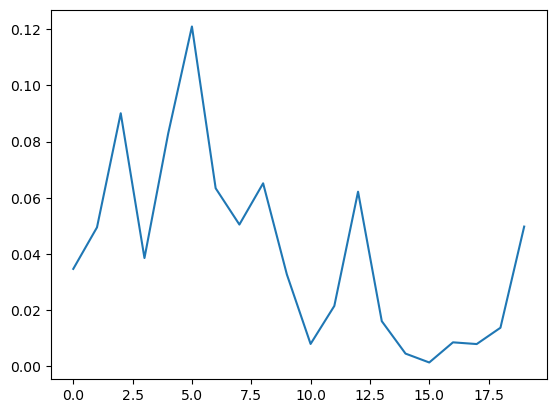

In [152]:
loss_log, acc_log = test(model, criterion)
plt.plot(loss_log);

Посмотрим на ошибки

In [153]:
def predict(model):
    X, y, logit = [], [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        with torch.no_grad():
            logits = model(x_batch)
            
        X.extend(x_batch.numpy()) # это плохо!
        y.extend(y_batch.numpy())
        logit.extend(torch.max(logits, 1)[1].data.numpy())
    return np.array(X), np.array(y), np.array(logit)

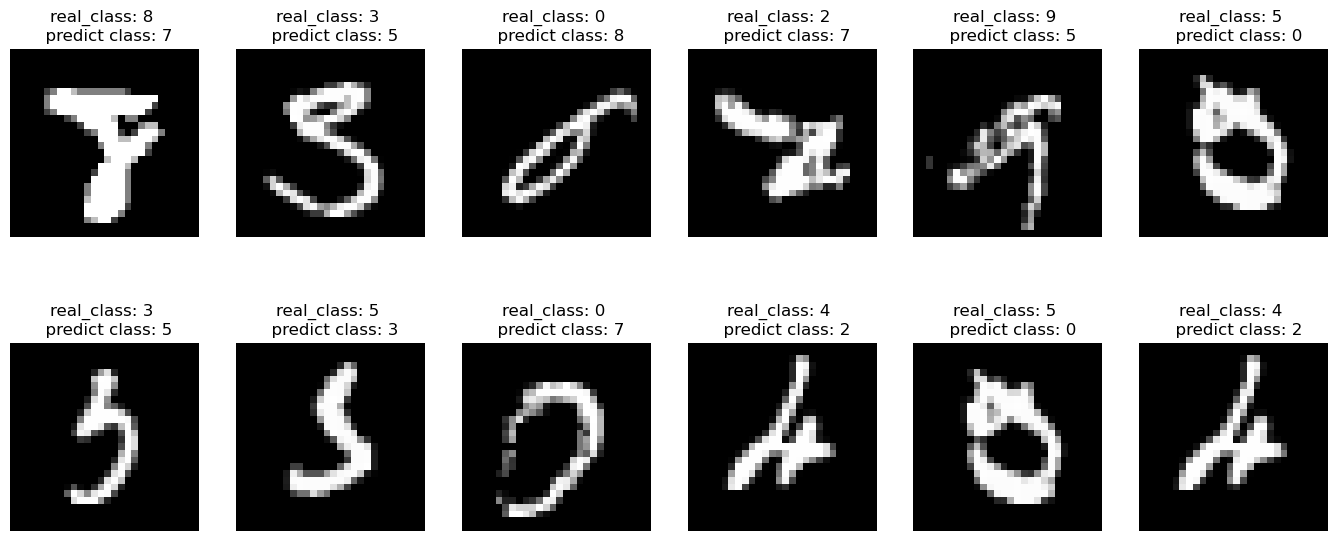

In [154]:
X_test, y_test, y_pred = predict(model)

errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

## Пункт 4

In [184]:
class Autoencoder(nn.Module):
    def __init__(self, image_channels=1, encoding_dim=32):
        super().__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, encoding_dim)
        )
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32*7*7),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [185]:
autoencoder = Autoencoder().to(device)
ae_criterion = nn.MSELoss()
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
ae_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(ae_optimizer, T_max=num_epochs)

In [186]:
def train_autoencoder(autoencoder, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        # Training
        autoencoder.train()
        train_loss = 0.0
        for images, _ in tqdm(train_loader, desc=f'Training AE {epoch+1}/{num_epochs}'):
            images = images.to(device)
            
            optimizer.zero_grad()
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        autoencoder.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in tqdm(val_loader, desc=f'Validating AE {epoch+1}/{num_epochs}'):
                images = images.to(device)
                reconstructed = autoencoder(images)
                loss = criterion(reconstructed, images)
                val_loss += loss.item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update scheduler
        ae_scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Visualize reconstructions every 5 epochs
        if (epoch+1) % 5 == 0:
            visualize_reconstructions(autoencoder, val_loader)
    
    return train_losses, val_losses

In [187]:
def visualize_reconstructions(model, loader, n=8):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images[:n].to(device)
        reconstructions = model(images).cpu()
    
    fig, axes = plt.subplots(2, n, figsize=(20, 4))
    for i in range(n):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

Training AE 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.5776, Val Loss: 0.5051


Training AE 2/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 2/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.4950, Val Loss: 0.4972


Training AE 3/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 3/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.4897, Val Loss: 0.4938


Training AE 4/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 4/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.4869, Val Loss: 0.4918


Training AE 5/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 5/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.4851, Val Loss: 0.4904


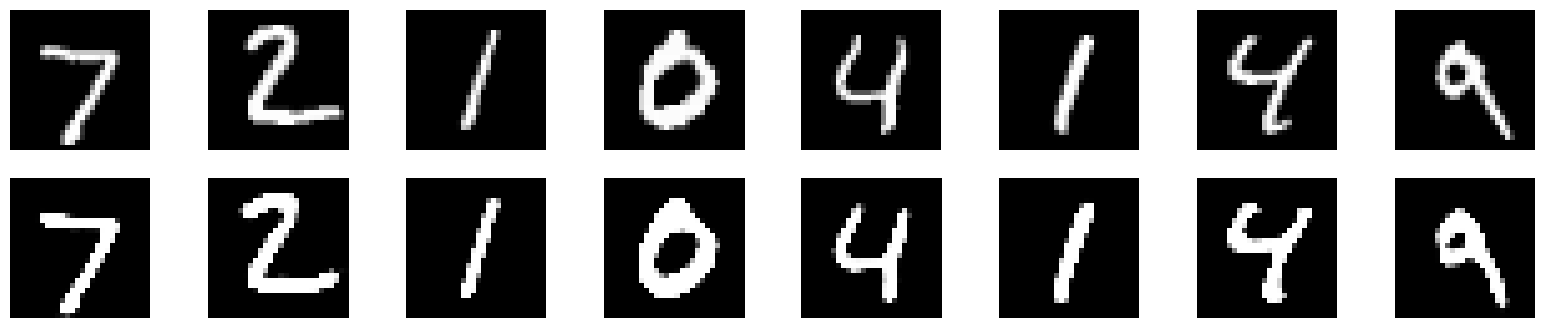

Training AE 6/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 6/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.4839, Val Loss: 0.4895


Training AE 7/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 7/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.4829, Val Loss: 0.4889


Training AE 8/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 8/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.4821, Val Loss: 0.4882


Training AE 9/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 9/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.4815, Val Loss: 0.4875


Training AE 10/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 10/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.4810, Val Loss: 0.4871


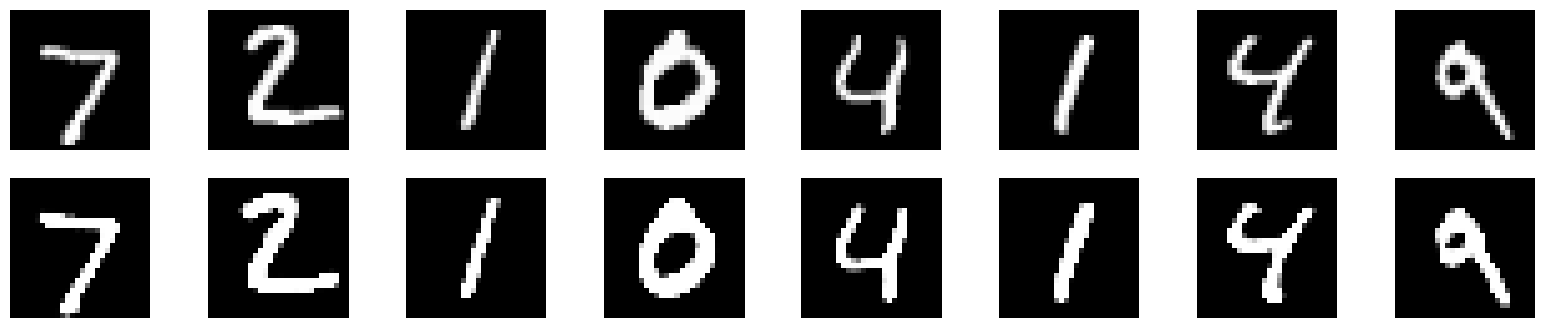

Training AE 11/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 11/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.4805, Val Loss: 0.4869


Training AE 12/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 12/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.4801, Val Loss: 0.4864


Training AE 13/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 13/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.4798, Val Loss: 0.4861


Training AE 14/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 14/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.4794, Val Loss: 0.4860


Training AE 15/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 15/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.4791, Val Loss: 0.4858


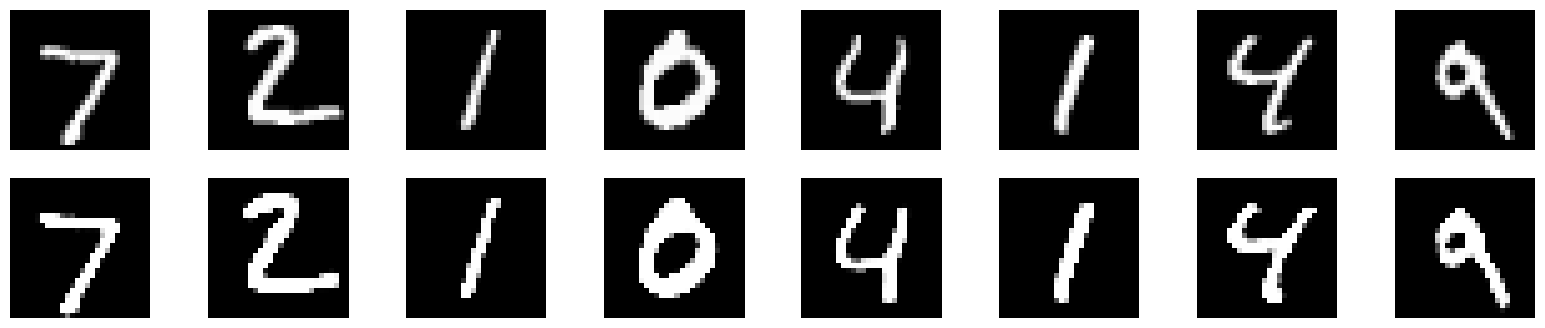

Training AE 16/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 16/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.4789, Val Loss: 0.4855


Training AE 17/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 17/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.4786, Val Loss: 0.4853


Training AE 18/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 18/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.4784, Val Loss: 0.4852


Training AE 19/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 19/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.4782, Val Loss: 0.4851


Training AE 20/20:   0%|          | 0/938 [00:00<?, ?it/s]

Validating AE 20/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.4781, Val Loss: 0.4849


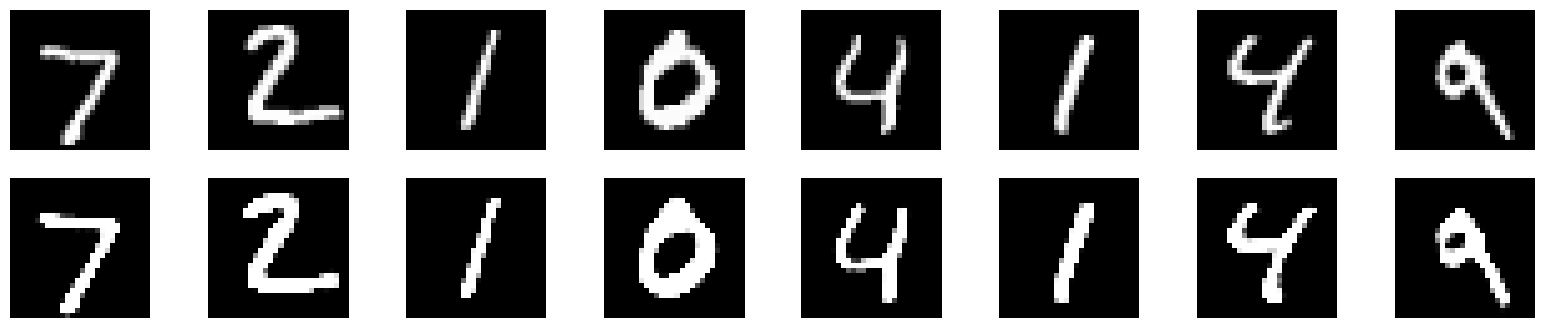

In [188]:
ae_train_losses, ae_val_losses = train_autoencoder(
    autoencoder, ae_optimizer, ae_criterion, train_loader, val_loader, num_epochs=20
)

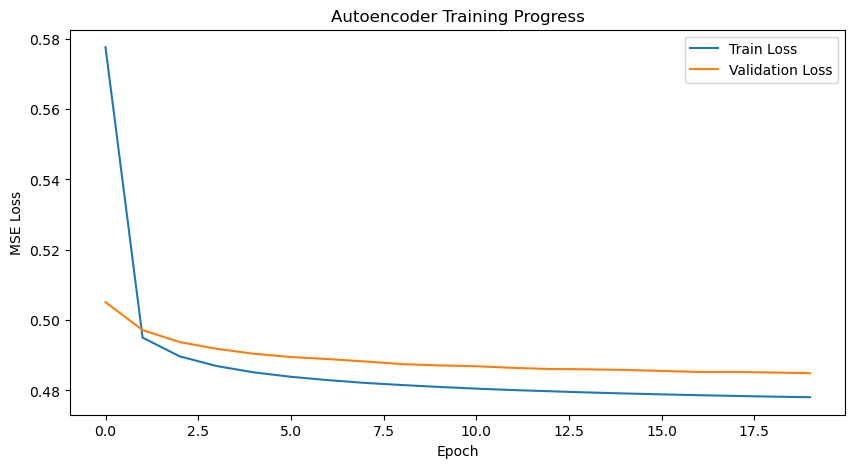

In [189]:
plt.figure(figsize=(10, 5))
plt.plot(ae_train_losses, label='Train Loss')
plt.plot(ae_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Progress')
plt.legend()
plt.show()